In [585]:
# Use mplcairo backend for emoji displaying.
import matplotlib
matplotlib.use("module://mplcairo.qt")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

import seaborn as sns
sns.set_theme(style="darkgrid", palette="Accent")

import datetime
from itertools import starmap

from IPython.display import Image, display
from io import BytesIO

from matplotlib.font_manager import FontProperties
# Load Apple Color Emoji font that is capable of displaying emojis. 
font = FontProperties(fname="../data/NotoColorEmoji-Regular.ttf")

import warnings
warnings.filterwarnings("ignore")

In [586]:
# We can't use %matplotlib inline to display plots inline because it switches the matplotlib backend,
# but emoji displaying only works with mplcairo backend.
# That's why we use this "hackish" function to be able to display plots inline. 
def display_plot(fig):
    with BytesIO() as buf:
        fig.savefig(buf, format="png", bbox_inches='tight')
        buf.seek(0)
        display(Image(data=buf.read(), format="png"))
    plt.close(fig)

In [587]:
# Function that adds data collection date and an author to the plot.
def add_date_and_author(ax, x: float, y: float, offset: float=0.03):
    today = datetime.date.today()
    ax.text(x, y, f"As of {today}", transform=ax.transAxes,
            fontsize=8, color="gray", ha="center", va="center")
    ax.text(x, y - offset, "by requef", transform=ax.transAxes,
            fontsize=8, color="gray", alpha=0.5, ha="center", va="center")

In [588]:
spins = pd.read_csv("./spins.csv")
spins.head()

,Spinner,Spin,Timestamp
0,HapticBM,🍋🍇🍋,2023-10-01T00:03:01.139Z
1,OSS_NCR,🍋🥒🍋,2023-10-01T00:03:34.598Z
2,kaijuD4C,🍋🍇🍇,2023-10-01T00:03:57.046Z
3,OSS_NCR,🍇🍇🥒,2023-10-01T00:04:19.767Z
4,OSS_NCR,🍇🍋🍊,2023-10-01T00:05:31.975Z


In [589]:
# Map timestamps to pandas datetime format.
spins.Timestamp = pd.to_datetime(spins.Timestamp, format="mixed")
spins = spins.rename(columns={"Timestamp": "Datetime"})

In [590]:
successful_spins = spins[spins.Spin.str.match(r"(\S)\1{2}")]
successful_spins.head()

,Spinner,Spin,Datetime
19,OSS_NCR,🍋🍋🍋,2023-10-01 00:49:02.947000+00:00
25,OSS_NCR,🍊🍊🍊,2023-10-01 01:01:53.178000+00:00
69,PvMKevin,🍊🍊🍊,2023-10-01 05:18:29.369000+00:00
95,requef,🍋🍋🍋,2023-10-01 12:02:40.013000+00:00
122,OSS_NCR,🍊🍊🍊,2023-10-01 14:37:21.365000+00:00


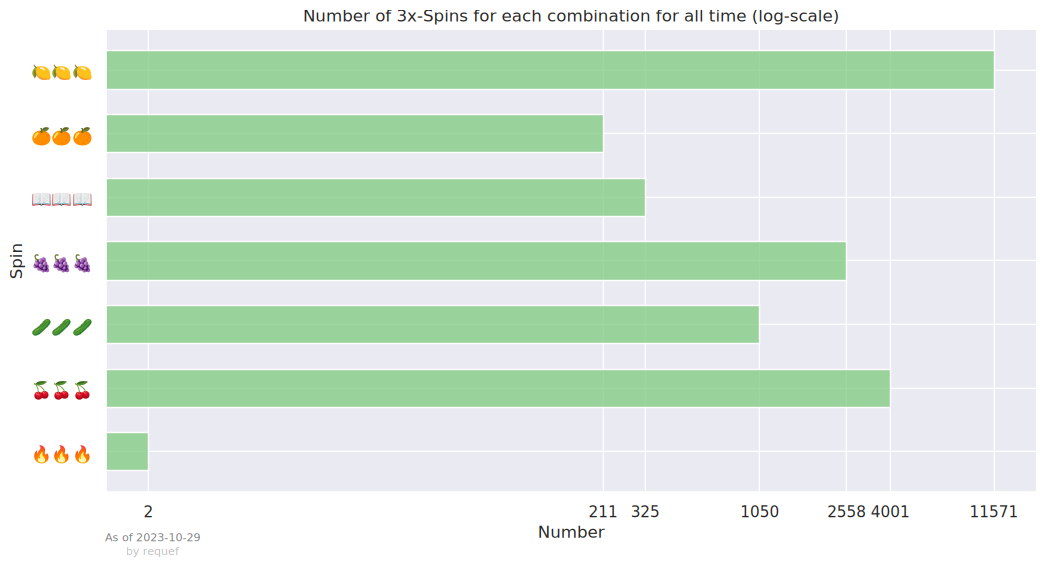

In [591]:
# Count of successful spins for all time.
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(fig)
hist = sns.histplot(successful_spins, y="Spin", log_scale=False, ax=ax, shrink=0.6)

plt.title("Number of 3x-Spins for each combination for all time (log-scale)")
ax.set_xscale('log')
ax.set_xlabel("Number")

hist.set_yticklabels([spin.get_text() for spin in hist.get_yticklabels()], fontproperties=font)
# set_xscale("log") set the formatter to a longer LogFormatter and ticks start to overlap.
# So we revert to a default ScalarFormatter.
hist.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
hist.set_xticks([r.get_width() for r in hist._children])

add_date_and_author(ax, 0.05, -0.1)
display_plot(fig)

In [592]:
spinners_by_spin = (successful_spins[["Spin", "Spinner"]]
                    .groupby("Spin")["Spinner"]
                    .value_counts()
                    .reset_index(name="Number")
                    .groupby("Spin")
                    .apply(lambda x: x.nlargest(10, "Number"))
                    .iloc[:, 1:]
                    .reset_index()
                    .drop("level_1", axis=1)
                    .sort_values("Number", ascending=False))

spinners_by_spin

,Spin,Spinner,Number
20,🍋🍋🍋,requef,280
21,🍋🍋🍋,2Manray,238
22,🍋🍋🍋,freecookiesss,173
23,🍋🍋🍋,CuteAnimeGirlfriend,164
24,🍋🍋🍋,kevinrez15,127
...,...,...,...
43,📖📖📖,casperblank,4
42,📖📖📖,joshzb,4
19,🍊🍊🍊,FlaminDemon,4
50,🔥🔥🔥,EORRIA,1


In [593]:
# Creating dominant color for each emoji for better visual cue.
emojis_color = { 
    "🍋🍋🍋": (181, 181, 42), 
    "🍊🍊🍊": (252, 105, 0), 
    "📖📖📖": (77, 145, 145),
    "🍇🍇🍇": (102, 0, 102),
    "🥒🥒🥒": (0, 153, 0),
    "🍒🍒🍒": (204, 0, 0),
    "🔥🔥🔥": (255, 172, 56) }

# Slightly tint each color.
for emoji in emojis_color.keys():
    emojis_color[emoji] = tuple(map(lambda v: v + 0.4*(255 - v), emojis_color[emoji]))

# Map to matplotlib's normalized color format.
for emoji in emojis_color.keys():
    emojis_color[emoji] = tuple(map(lambda v: v / 255, emojis_color[emoji]))

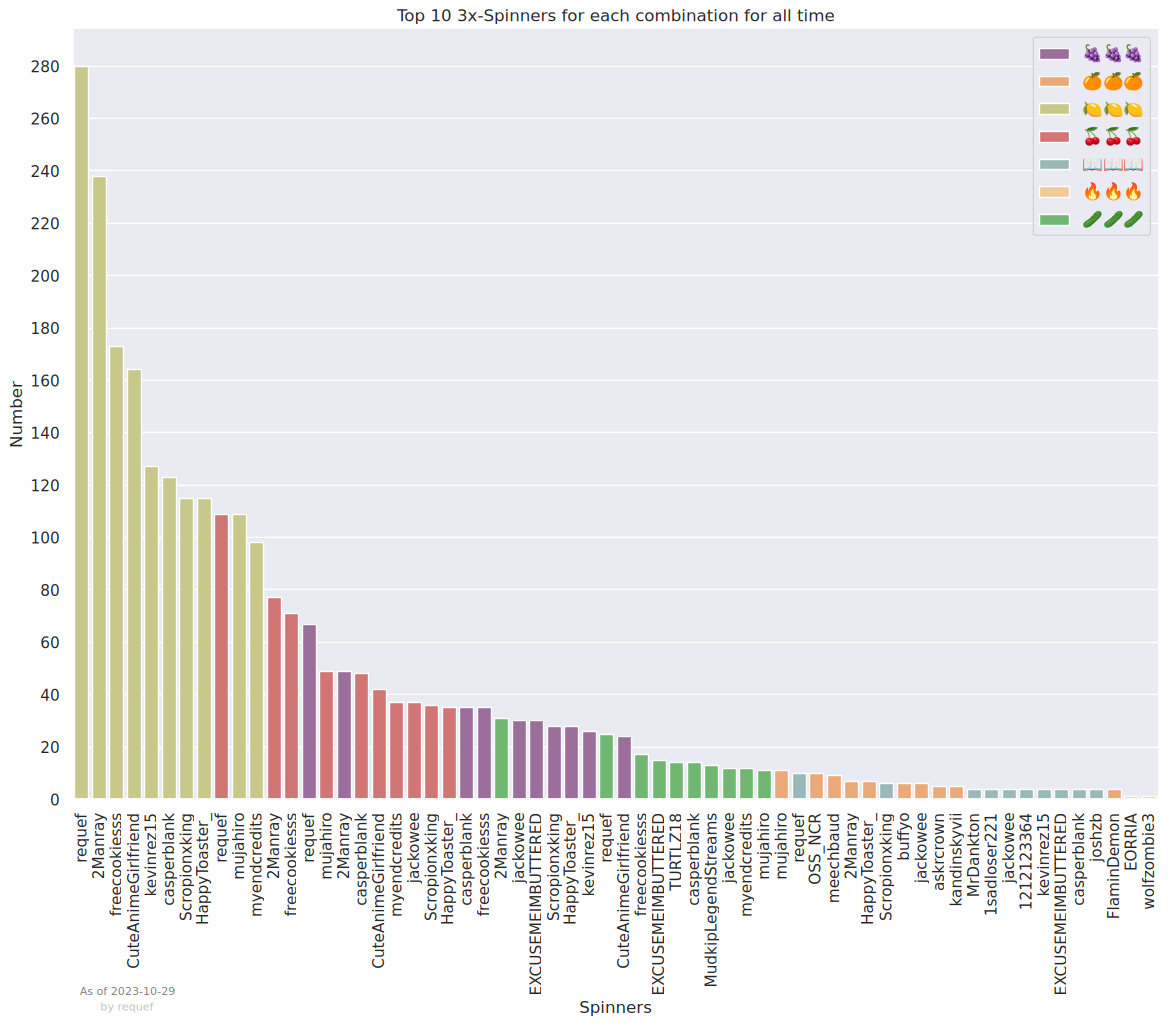

In [594]:
# Top 10 3x-Spinners for each combination for all time.
fig, ax = plt.subplots(figsize=(14, 10))
sns.despine(fig)
hist = sns.barplot(data=spinners_by_spin, 
                   x=spinners_by_spin.index, 
                   y="Number", 
                   hue="Spin", 
                   palette=emojis_color, 
                   order=spinners_by_spin.index,
                   ax=ax)

plt.title("Top 10 3x-Spinners for each combination for all time")
ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Spinners")
ax.set_xticklabels([ spinners_by_spin.loc[idx].Spinner for idx in spinners_by_spin.index ])
ax.set_yticks([i for i in range(0, 300, 20)])

legend = ax.legend()
plt.setp(legend.texts, fontproperties=font)

add_date_and_author(ax, 0.05, -0.25, 0.02)
display_plot(fig)

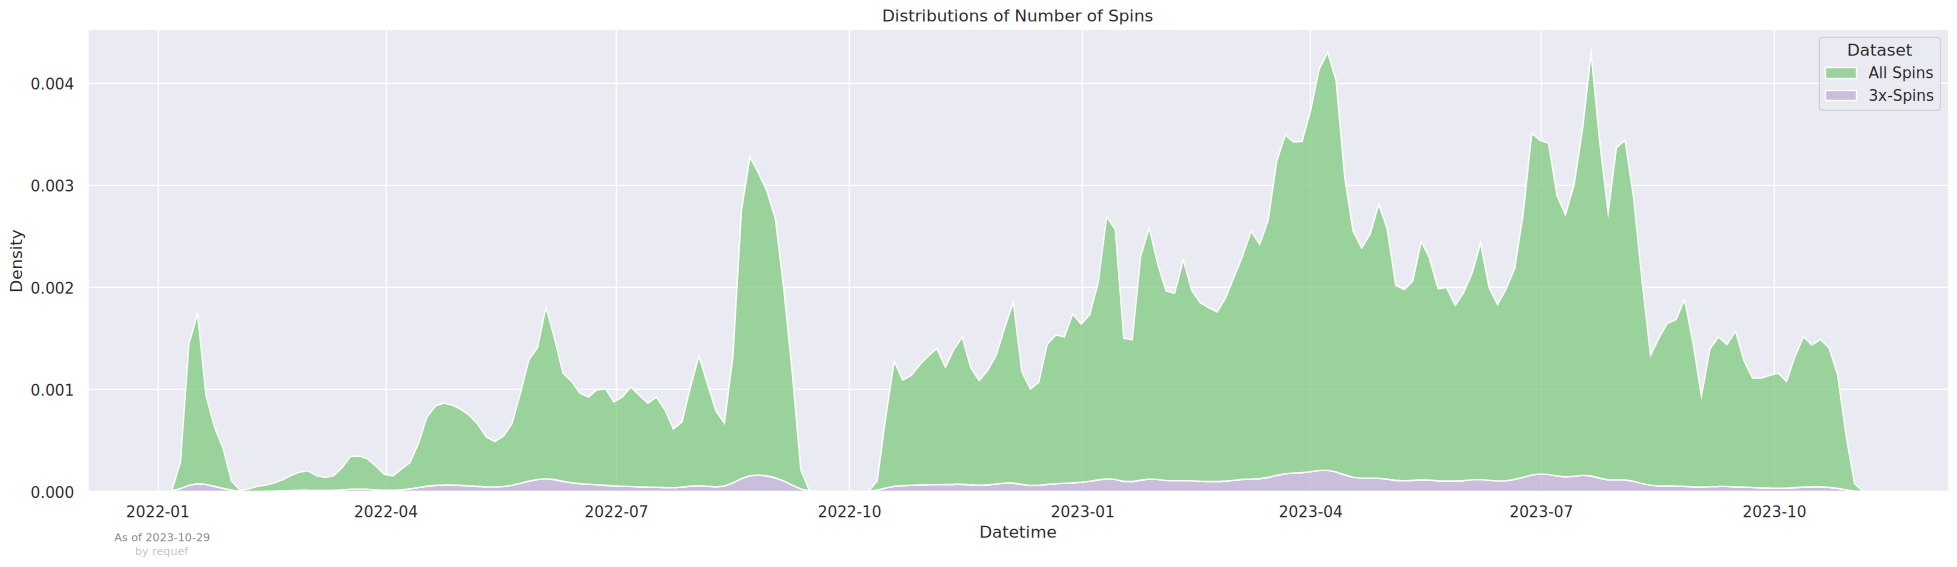

In [595]:
# Distributions of Number of Spins.
concat_spins_by_day = pd.concat([spins[["Spin", "Datetime"]].set_index("Datetime").assign(Dataset="All Spins"), 
                                 successful_spins[["Spin", "Datetime"]].set_index("Datetime").assign(Dataset="3x-Spins")])

fig, ax = plt.subplots(figsize=(24, 6))
sns.despine(fig)
sns.kdeplot(data=concat_spins_by_day, x="Datetime", hue="Dataset", multiple="stack", bw_adjust=0.2, ax=ax)
plt.title("Distributions of Number of Spins")

add_date_and_author(ax, 0.04, -0.1, 0.03)
display_plot(fig)

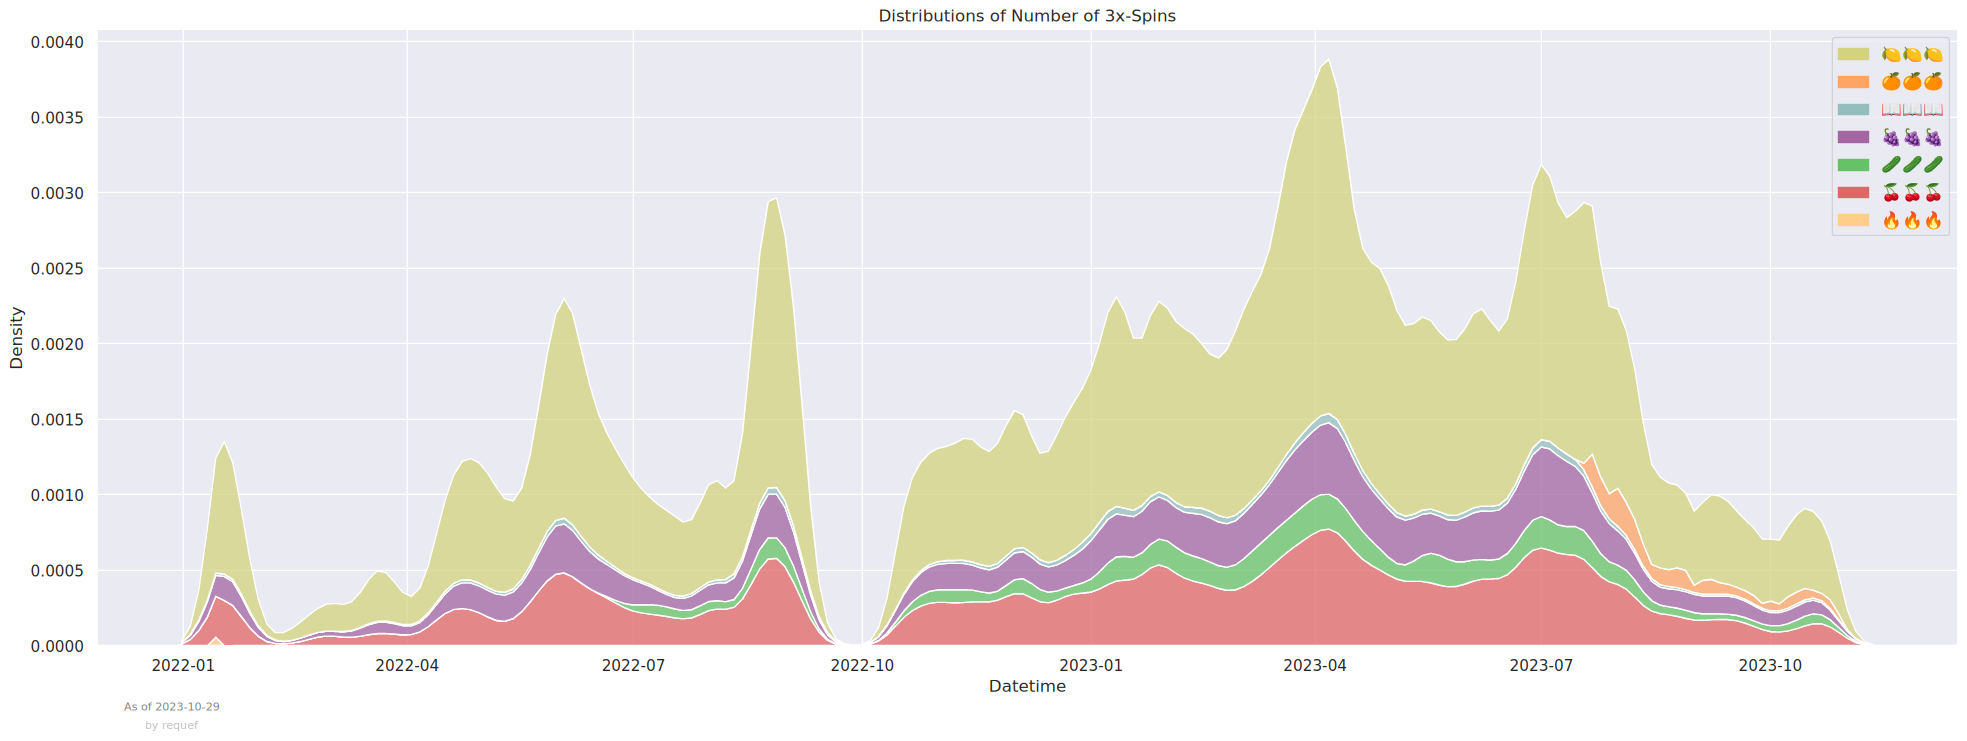

In [596]:
# Number of each 3x-combination spin for each day.
fig, ax = plt.subplots(figsize=(24, 8))
sns.despine(fig)
sns.kdeplot(data=successful_spins, 
            x="Datetime",  
            hue="Spin",  
            multiple="stack",
            bw_adjust=0.2,
            palette=emojis_color,
            legend=False, 
            ax=ax)

plt.title("Distributions of Number of 3x-Spins")

# Manually creating legend, because it's doesn't exist at this point and we can't customise it.
# See: https://github.com/mwaskom/seaborn/issues/2761.    
legend = ax.legend(handles=[ mpatches.Patch(color=color, label=emoji) for emoji, color in emojis_color.items() ])
plt.setp(legend.texts, fontproperties=font)

add_date_and_author(ax, 0.04, -0.1, 0.03)
display_plot(fig)

In [597]:
spin_counts_by_name = (spins[["Spinner", "Spin"]]
                       .groupby("Spinner")
                       .count()
                       .nlargest(50, "Spin")
                       .rename(columns={"Spin": "Total"})
                       .reset_index()
                       .join(successful_spins[["Spinner", "Spin"]]
                             .groupby("Spinner")
                             .count()
                             .rename(columns={"Spin": "3x-Spins"}), on="Spinner"))
spin_counts_by_name

,Spinner,Total,3x-Spins
0,requef,9221,494
1,2Manray,7410,405
2,freecookiesss,5212,300
3,casperblank,4223,225
4,mujahiro,3983,203
5,HappyToaster_,3440,194
6,CuteAnimeGirlfriend,3438,242
7,EXCUSEMEIMBUTTERED,3114,169
8,jackowee,3017,184
9,myendcredits,3014,170


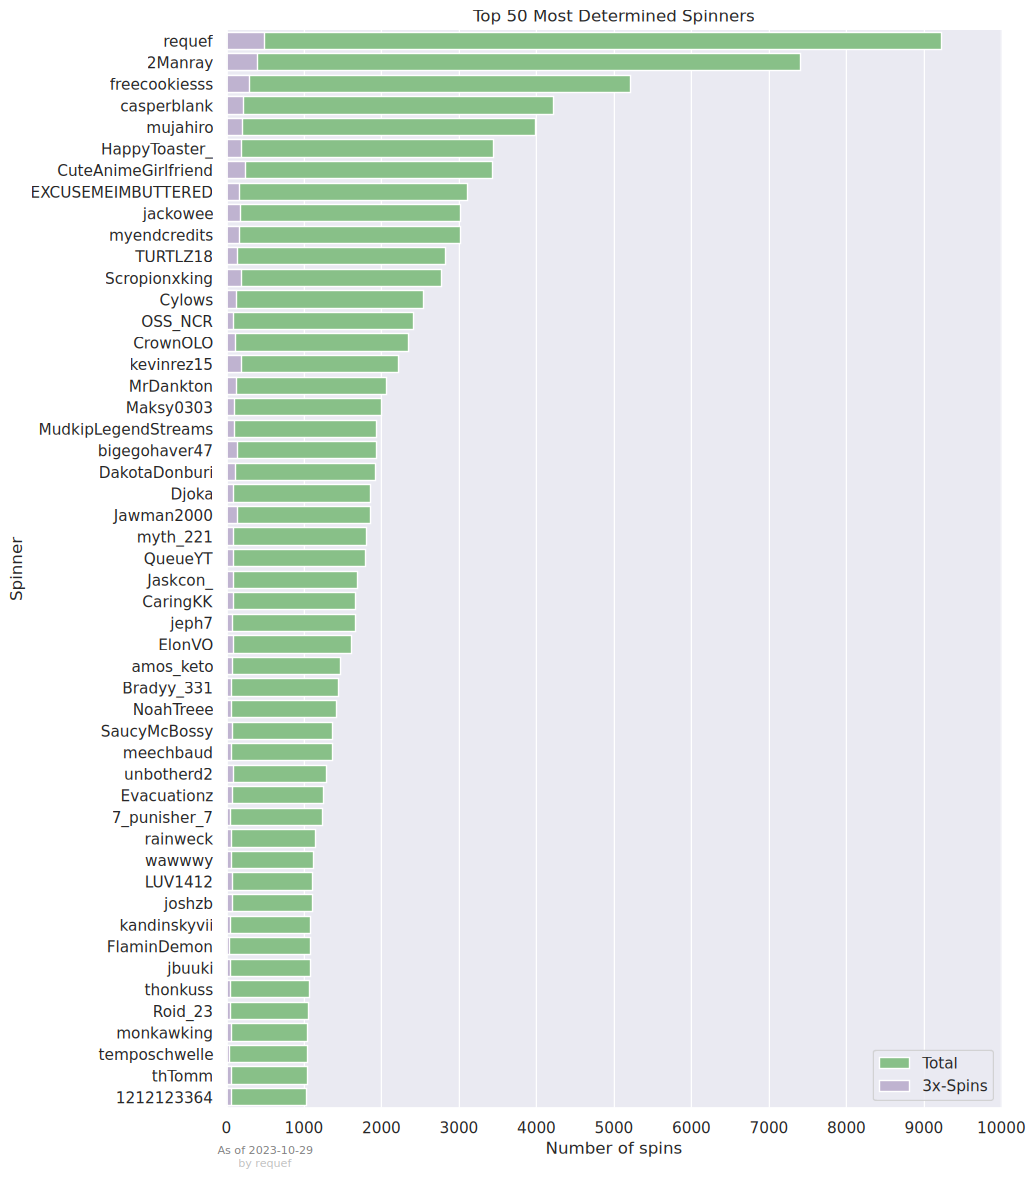

In [598]:
# Top 50 most determined spinners.
fig, ax = plt.subplots(figsize=(10, 14))
sns.despine(fig)

sns.barplot(data=spin_counts_by_name, 
            y="Spinner", 
            x="Total",
            label="Total",
            ax=ax)

sns.barplot(data=spin_counts_by_name, 
            y="Spinner", 
            x="3x-Spins",
            label="3x-Spins",
            ax=ax)

plt.title("Top 50 Most Determined Spinners")
ax.set_xlabel("Number of spins")
ax.set_xticks([i for i in range(0, 10001, 1000)])

add_date_and_author(ax, 0.05, -0.04, 0.012)
display_plot(fig)

In [599]:
top10_spinners_datetime = pd.merge(spins[["Spinner", "Datetime"]], spin_counts_by_name.Spinner[:10], on="Spinner", how="right")
top10_spinners_datetime

,Spinner,Datetime
0,requef,2023-10-01 12:02:40.013000+00:00
1,requef,2023-10-01 16:58:25.899000+00:00
2,requef,2023-10-01 17:00:12.462000+00:00
3,requef,2023-10-01 17:00:46.762000+00:00
4,requef,2023-10-01 17:09:43.578000+00:00
...,...,...
46067,myendcredits,2023-03-31 23:52:07.594000+00:00
46068,myendcredits,2023-03-31 23:52:24.434000+00:00
46069,myendcredits,2023-03-31 23:54:07.110000+00:00
46070,myendcredits,2023-03-31 23:56:32.223000+00:00


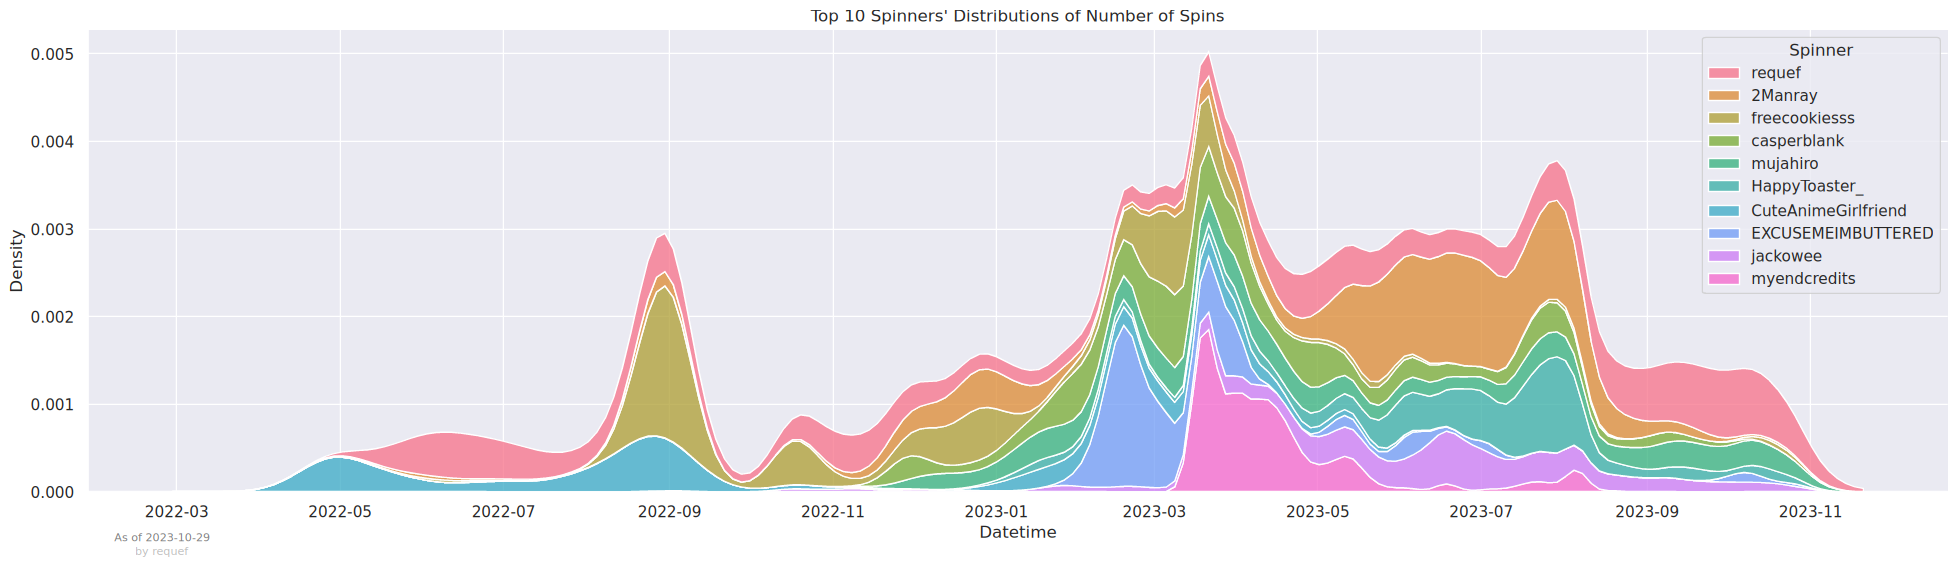

In [600]:
# Top 10 Spinners' Distributions of Number of Spins for Each Day.
fig, ax = plt.subplots(figsize=(24, 6))
sns.despine(fig)
sns.kdeplot(data=top10_spinners_datetime, x="Datetime", hue="Spinner", bw_adjust=0.5, multiple="stack", ax=ax)
plt.title("Top 10 Spinners' Distributions of Number of Spins")

add_date_and_author(ax, 0.04, -0.1, 0.03)
display_plot(fig)